# Quantium Virtual Internship - Retail Strategy and Analytics - Task 2

## Load required libraries and datasets

In [7]:
library(data.table)
library(ggplot2)
library(tidyr)

#### Point the filePath to where you have downloaded the datasets to and
#### assign the data files to data.tables

In [8]:
data <- fread(paste0("QVI_data.csv"))
#### Set themes for plots
theme_set(theme_bw())
theme_update(plot.title = element_text(hjust = 0.5))

## Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer
Let's first create the metrics of interest and filter to stores that are present
throughout the pre-trial period.

In [9]:
#### Calculate these measures over time for each store
#### Add a new month ID column in the data with the format yyyymm.
data[, YEARMONTH := year(DATE)*100 + month(DATE)]
data
#### Next, we define the measure calculations to use during the analysis.
# For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.
measureOverTime <- data[, .(totSales = sum(TOT_SALES),
                            nCustomers = uniqueN(LYLTY_CARD_NBR) ,
                            nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
                            nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID),
                            avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY))
                        , by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH) ]
#### Filter to the pre-trial period and stores with full observation periods
storesWithFullObs <- unique(measureOverTime[, .N, STORE_NBR][N == 12, STORE_NBR])
preTrialMeasures <- measureOverTime[YEARMONTH < 201902 & STORE_NBR %in%
storesWithFullObs, ]

LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
<int>,<IDate>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>
1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811
1005,2018-12-28,1,6,86,Cheetos Puffs 165g,1,2.8,165,CHEETOS,MIDAGE SINGLES/COUPLES,Mainstream,201812
1007,2018-12-04,1,7,49,Infuzions SourCream&Herbs Veg Strws 110g,1,3.8,110,INFUZIONS,YOUNG SINGLES/COUPLES,Budget,201812
1007,2018-12-05,1,8,10,RRD SR Slow Rst Pork Belly 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Budget,201812
1009,2018-11-20,1,9,20,Doritos Cheese Supreme 330g,1,5.7,330,DORITOS,NEW FAMILIES,Premium,201811


Now we need to work out a way of ranking how similar each potential control store
is to the trial store. We can calculate how correlated the performance of each
store is to the trial store.
Let's write a function for this so that we don't have to calculate this for each
trial store and control store pair.

In [10]:
calculateCorrelation <- function(inputTable, metricCol, storeComparison) {
  calcCorrTable = data.table(Store1 = numeric(), Store2 = numeric(), corr_measure =
  numeric())

  storeNumbers <- unique(inputTable[, STORE_NBR])
  
  for (i in storeNumbers) {
    calculatedMeasure = data.table("Store1" = storeComparison,
                                   "Store2" = i,
                                   "corr_measure" = cor( inputTable[STORE_NBR == storeComparison,
                                                                     eval(metricCol)], inputTable[STORE_NBR == i,
                                                                                                eval(metricCol)]))
    calcCorrTable <- rbind(calcCorrTable, calculatedMeasure)
  }
  return(calcCorrTable)
}

Apart from correlation, we can also calculate a standardised metric based on the
absolute difference between the trial store's performance and each control store's
performance.
Let's write a function for this.

In [11]:
calculateMagnitudeDistance <- function(inputTable, metricCol, storeComparison) {
calcDistTable = data.table(Store1 = numeric(), Store2 = numeric(), YEARMONTH =
numeric(), measure = numeric())
  storeNumbers <- unique(inputTable[, STORE_NBR])
  for (i in storeNumbers) {
  calculatedMeasure = data.table("Store1" = storeComparison
                                 , "Store2" = i
                                 , "YEARMONTH" = inputTable[STORE_NBR ==
storeComparison, YEARMONTH]
                                 , "measure" = abs(inputTable[STORE_NBR ==
storeComparison, eval(metricCol)]
                                                   - inputTable[STORE_NBR == i,
eval(metricCol)])
                                  )
    calcDistTable <- rbind(calcDistTable, calculatedMeasure)
}
#### Standardise the magnitude distance so that the measure ranges from 0 to 1
  minMaxDist <- calcDistTable[, .(minDist = min(measure), maxDist = max(measure)),
by = c("Store1", "YEARMONTH")]
  distTable <- merge(calcDistTable, minMaxDist, by = c("Store1", "YEARMONTH"))
  distTable[, magnitudeMeasure := 1 - (measure - minDist)/(maxDist - minDist)]
  finalDistTable <- distTable[, .(mag_measure = mean(magnitudeMeasure)), by =
.(Store1, Store2)]
  return(finalDistTable)
}

Now let's use the functions to find the control stores! We'll select control stores
based on how similar monthly total sales in dollar amounts and monthly number of
customers are to the trial stores. So we will need to use our functions to get four
scores, two for each of total sales and total customers.

In [12]:
trial_store <- 77
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nSales[order(-corr_measure)]
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)
corr_nCustomers[order(-corr_measure)]
#### Then, use the functions for calculating magnitude.
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales),
trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures,
quote(nCustomers), trial_store)

Store1,Store2,corr_measure
<dbl>,<dbl>,<dbl>
77,77,1.0000000
77,71,0.9141060
77,233,0.9037742
77,119,0.8676644
77,17,0.8426684
77,3,0.8066436
77,41,0.7832319
77,50,0.7638658
77,157,0.7358932


Store1,Store2,corr_measure
<dbl>,<dbl>,<dbl>
77,77,1.0000000
77,233,0.9903578
77,119,0.9832666
77,254,0.9162084
77,113,0.9013480
77,84,0.8585712
77,41,0.8442195
77,3,0.8342074
77,35,0.7746471


We'll need to combine the all the scores calculated using our function to create a
composite score to rank on.
Let's take a simple average of the correlation and magnitude scores for each
driver. Note that if we consider it more important for the trend of the drivers to
be similar, we can increase the weight of the correlation score (a simple average
gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of
the drivers to be more important, we can lower the weight of the correlation score.

In [13]:
corr_weight <- 0.5
score_nSales <- merge(corr_nSales, magnitude_nSales, by = 
          c("Store1","Store2"))[, scoreNSales := (corr_measure + mag_measure)/2 ]
score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by =
        c("Store1", "Store2"))[, scoreNCust := (corr_measure + mag_measure)/2]

In [14]:
score_nSales[order(-scoreNSales)]

Store1,Store2,corr_measure,mag_measure,scoreNSales
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,77,1.0000000,1.0000000,1.0000000
77,233,0.9037742,0.9852649,0.9445195
77,41,0.7832319,0.9651401,0.8741860
77,50,0.7638658,0.9731293,0.8684976
77,17,0.8426684,0.8806882,0.8616783
77,115,0.6891588,0.9328321,0.8109955
77,167,0.6571104,0.9591332,0.8081218
77,265,0.6397594,0.9626629,0.8012111
77,234,0.6963248,0.8903392,0.7933320


In [15]:
score_nCustomers[order(-scoreNCust)]

Store1,Store2,corr_measure,mag_measure,scoreNCust
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,77,1.0000000,1.0000000,1.0000000
77,233,0.9903578,0.9927733,0.9915655
77,254,0.9162084,0.9371312,0.9266698
77,41,0.8442195,0.9746392,0.9094294
77,84,0.8585712,0.9241818,0.8913765
77,17,0.7473078,0.9624953,0.8549015
77,115,0.7188818,0.9659160,0.8423989
77,35,0.7746471,0.9069267,0.8407869
77,167,0.7179126,0.9493491,0.8336309


Now we have a score for each of total number of sales and number of customers.
Let's combine the two via a simple average.

In [16]:
score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1","Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

In [17]:
score_Control[order(-finalControlScore)]

Store1,Store2,corr_measure.x,mag_measure.x,scoreNSales,corr_measure.y,mag_measure.y,scoreNCust,finalControlScore
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,77,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
77,233,0.9037742,0.9852649,0.9445195,0.9903578,0.9927733,0.9915655,0.9680425
77,41,0.7832319,0.9651401,0.8741860,0.8442195,0.9746392,0.9094294,0.8918077
77,17,0.8426684,0.8806882,0.8616783,0.7473078,0.9624953,0.8549015,0.8582899
77,254,0.5771085,0.9227714,0.7499399,0.9162084,0.9371312,0.9266698,0.8383049
77,115,0.6891588,0.9328321,0.8109955,0.7188818,0.9659160,0.8423989,0.8266972
77,84,0.6843478,0.8300852,0.7572165,0.8585712,0.9241818,0.8913765,0.8242965
77,167,0.6571104,0.9591332,0.8081218,0.7179126,0.9493491,0.8336309,0.8208763
77,50,0.7638658,0.9731293,0.8684976,0.6073908,0.9250762,0.7662335,0.8173655


The store with the highest score is then selected as the control store since it is
most similar to the trial store.

In [18]:
control_store <- score_Control[Store1 == trial_store, ][order(-finalControlScore)][2, Store2]
control_store

[1] 233

Now that we have found a control store, let's check visually if the drivers are
indeed similar in the period before the trial.
We'll look at total sales first.

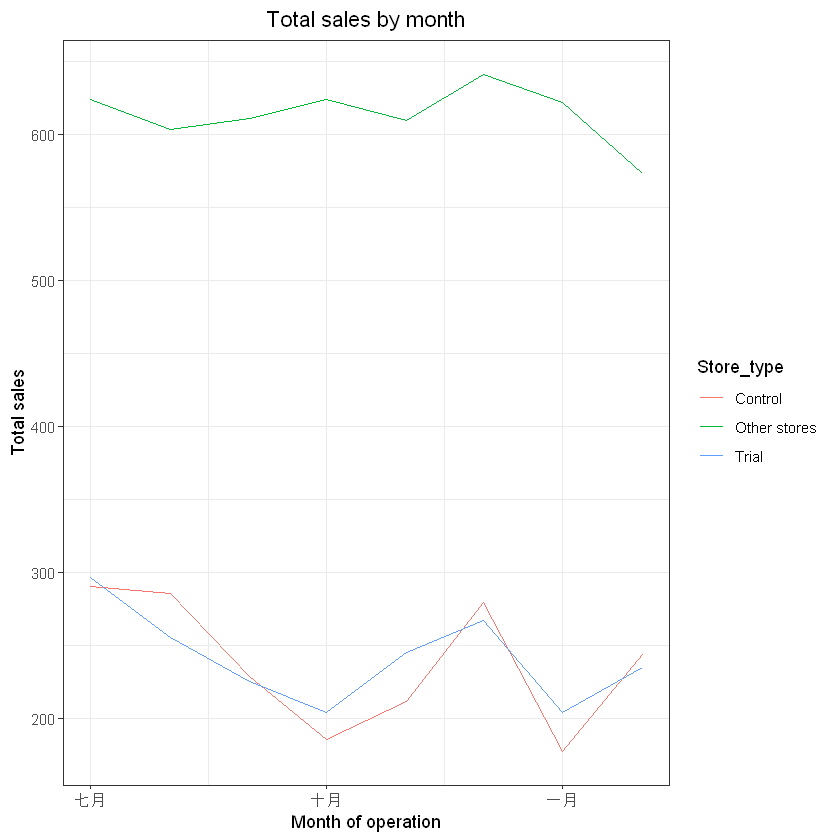

In [19]:
measureOverTimeSales <- measureOverTime

pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store,
"Trial",
                                          ifelse(STORE_NBR == control_store,
"Control", "Other stores"))
                              ][, totSales := mean(totSales), by = c("YEARMONTH",
"Store_type")
                              ][, TransactionMonth := as.Date(paste(YEARMONTH %/%
100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
                              ][YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_line() +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

Next, number of customers.

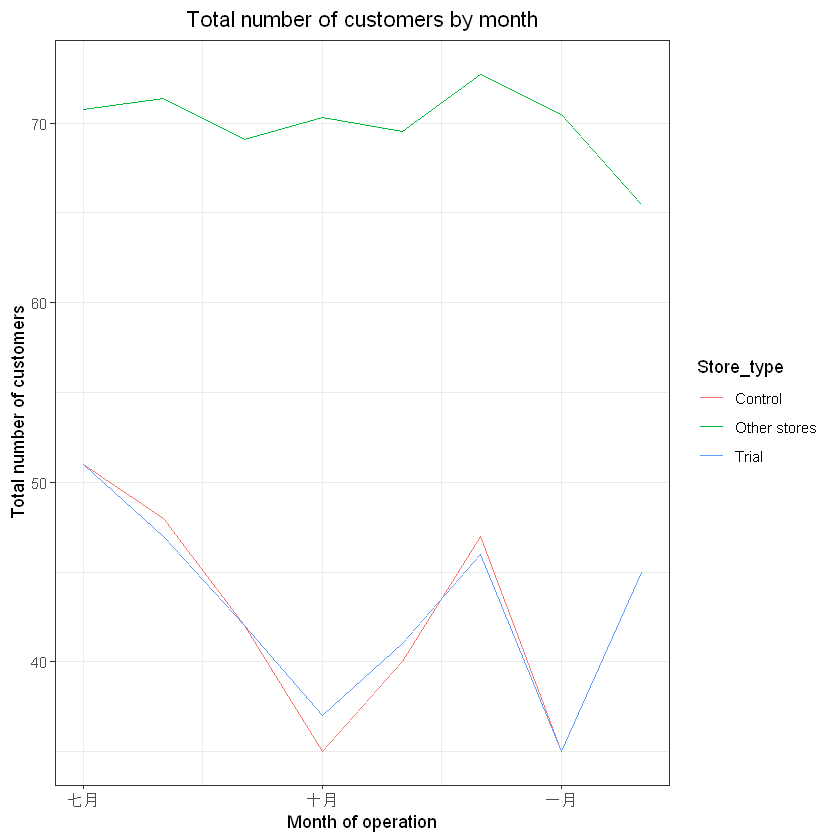

In [20]:
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                                      ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
][YEARMONTH < 201903 , ]
ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) +
  geom_line() +
  labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

## Assessment of trial

The trial period goes from the start of February 2019 to April 2019. We now want to
see if there has been an uplift in overall chip sales.
We'll start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.

In [21]:
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR == control_store &
YEARMONTH < 201902, sum(totSales)]
#### Apply the scaling factor
measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][ ,
controlSales := totSales * scalingFactorForControlSales]

Now that we have comparable sales figures for the control store, we can calculate
the percentage difference between the scaled control sales and the trial store's
sales during the trial period.

In [22]:
percentageDiff <- merge(scaledControlSales[, c("YEARMONTH", "controlSales")],
                        measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],
                        by = "YEARMONTH")[, percentageDiff := abs(controlSales-totSales)/controlSales]

In [23]:
percentageDiff # between control store sales and trial store sales

Let's see if the difference is significant!

In [24]:
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])

In [25]:
degreesOfFreedom <- 7

In [26]:
percentageDiff[, tValue := (percentageDiff - 0)/stdDev
               ][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, 
                                                     sep = "-"), "%Y-%m-%d")
][YEARMONTH < 201905 & YEARMONTH > 201901, .(TransactionMonth,tValue)]

TransactionMonth,tValue
<date>,<dbl>
2019-02-01,1.183534
2019-03-01,7.339116
2019-04-01,12.476373


In [27]:
qt(0.95, df = degreesOfFreedom)

[1] 1.894579

We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.
Let's create a more visual version of this by plotting the sales of the control
store, the sales of the trial stores and the 95th percentile value of sales of the
control store.

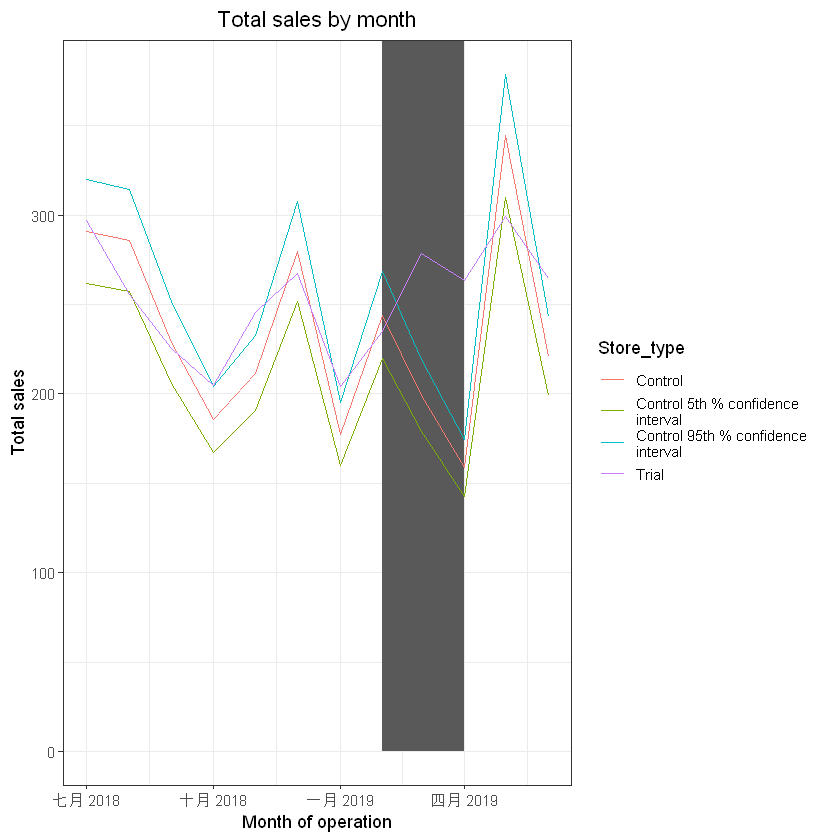

In [28]:
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
][Store_type %in% c("Trial", "Control"), ]

#### Control store 95th percentile
pastSales_Controls95 <- pastSales[Store_type == "Control",
 ][, totSales := totSales * (1 + stdDev * 2)
 ][, Store_type := "Control 95th % confidence
interval"]

#### Control store 5th percentile
pastSales_Controls5 <- pastSales[Store_type == "Control",
 ][, totSales := totSales * (1 - stdDev * 2)
 ][, Store_type := "Control 5th % confidence
interval"]
trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 , ymax =
Inf, color = NULL), show.legend = FALSE) +
  geom_line() +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.
Let's have a look at assessing this for number of customers as well.

In [29]:
scalingFactorForControlCust <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)] / preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(nCustomers)]
measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR ==trial_store, "Trial",
ifelse(STORE_NBR == control_store,"Control", "Other stores"))]
percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],
measureOverTimeCusts[STORE_NBR == trial_store,c("nCustomers", "YEARMONTH")],
by = "YEARMONTH"
)[, percentageDiff := abs(controlCustomers-nCustomers)/controlCustomers]

Let's again see if the difference is significant visually!

In [30]:
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom <- 7

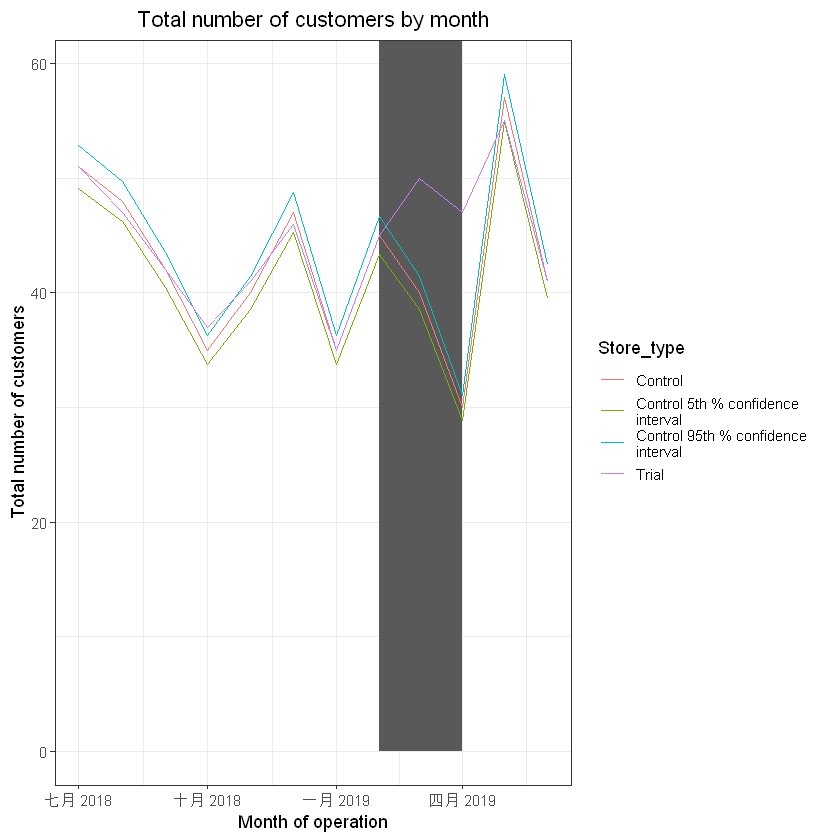

In [31]:
pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by =
c("YEARMONTH", "Store_type")
                            ][Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",
                                ][, nCusts := nCusts * (1 + stdDev * 2)
                                ][, Store_type := "Control 95th % confidence
interval"]
#### Control store 5th percentile
pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
                                ][, nCusts := nCusts * (1 - stdDev * 2)
                                ][, Store_type := "Control 5th % confidence
interval"]
trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95,
pastCustomers_Controls5)
#### Plot everything into one nice graph.
#### geom_rect creates a rectangle in the plot. Use this to highlight the
#### trial period in our graph.
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) + 
  geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + 
  geom_line() + labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

Let's repeat finding the control store and assessing the impact of the trial for
each of the other two trial stores.
## Trial store 86

In [32]:
measureOverTime <- data[, .(totSales = sum(TOT_SALES),
                            nCustomers = uniqueN(LYLTY_CARD_NBR),
                            nTxnPerCust = (uniqueN(TXN_ID))/(uniqueN(LYLTY_CARD_NBR)),
                            nChipsPerTxn = (sum(PROD_QTY))/(uniqueN(TXN_ID)) , 
                            avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY) ) , by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]

#### Use the functions we created earlier to calculate correlations and magnitude for each potential control store
trial_store <- 86
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales),trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)
#### Now, create a combined score composed of correlation and magnitude
corr_weight <- 0.5
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))[ , scoreNSales := (corr_measure + mag_measure)/2]
score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[ , scoreNCust := (corr_measure + mag_measure)/2]

#### Finally, combine scores across the drivers using a simple average.
score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1","Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]
#### Select control stores based on the highest matching store
#### (closest to 1 but not the store itself, i.e. the second ranked highest store)
#### Select control store for trial store 86
control_store <- score_Control[Store1 == trial_store,
][order(-finalControlScore)][2, Store2]
control_store

[1] 155

Looks like store 155 will be a control store for trial store 86.
Again, let's check visually if the drivers are indeed similar in the period before
the trial.
We'll look at total sales first.

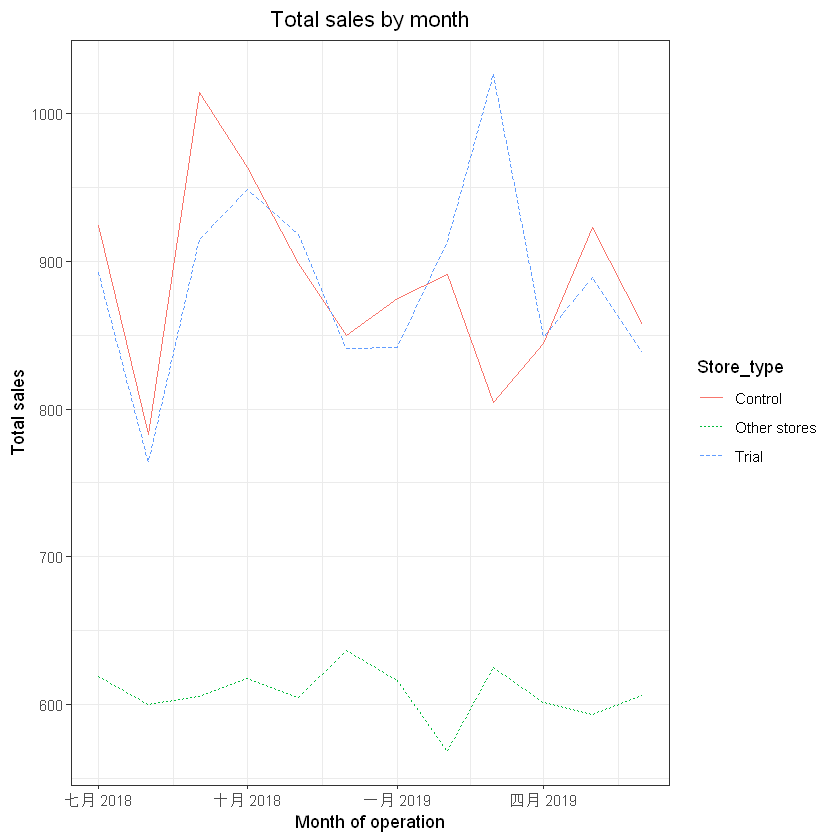

In [33]:
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type:= ifelse(STORE_NBR == trial_store, "Trial", ifelse(STORE_NBR== control_store, "Control", "Other stores"))][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")][, TransactionMonth:= as.Date(paste(YEARMONTH%/%100, YEARMONTH%% 100, 1, sep = "-"), "%Y-%m-%d")][YEARMONTH <210903] 

ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_line(aes(linetype = Store_type)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

Great, sales are trending in a similar way.
Next, number of customers.

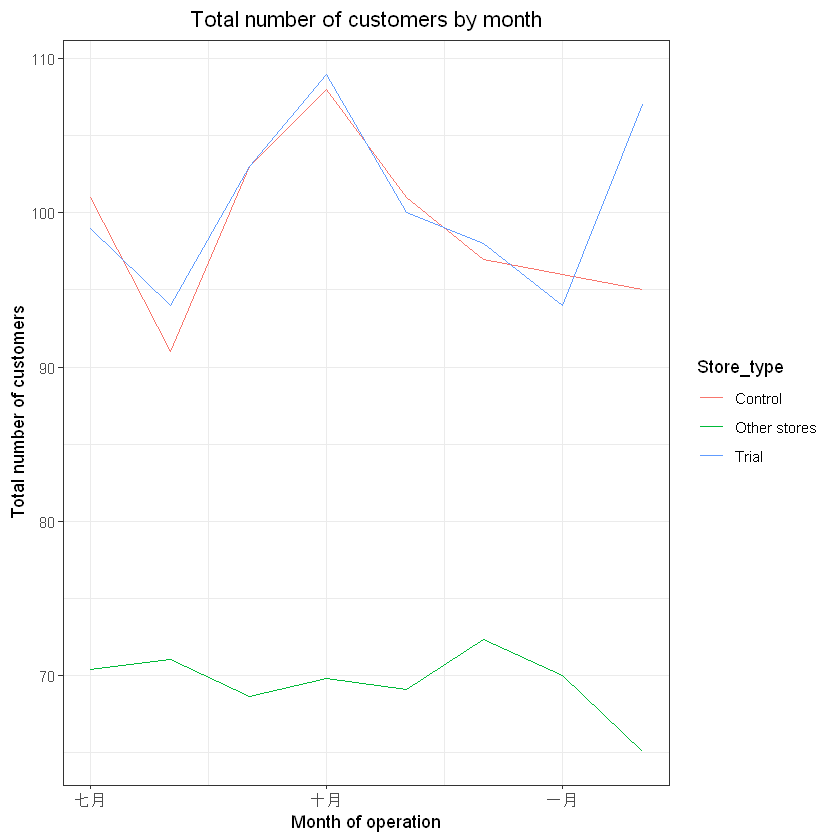

In [34]:
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/%
                                        100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
][YEARMONTH < 201903 , ]

ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) + 
  geom_line() + 
  labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

Good, the trend in number of customers is also similar.
Let's now assess the impact of the trial on sales.

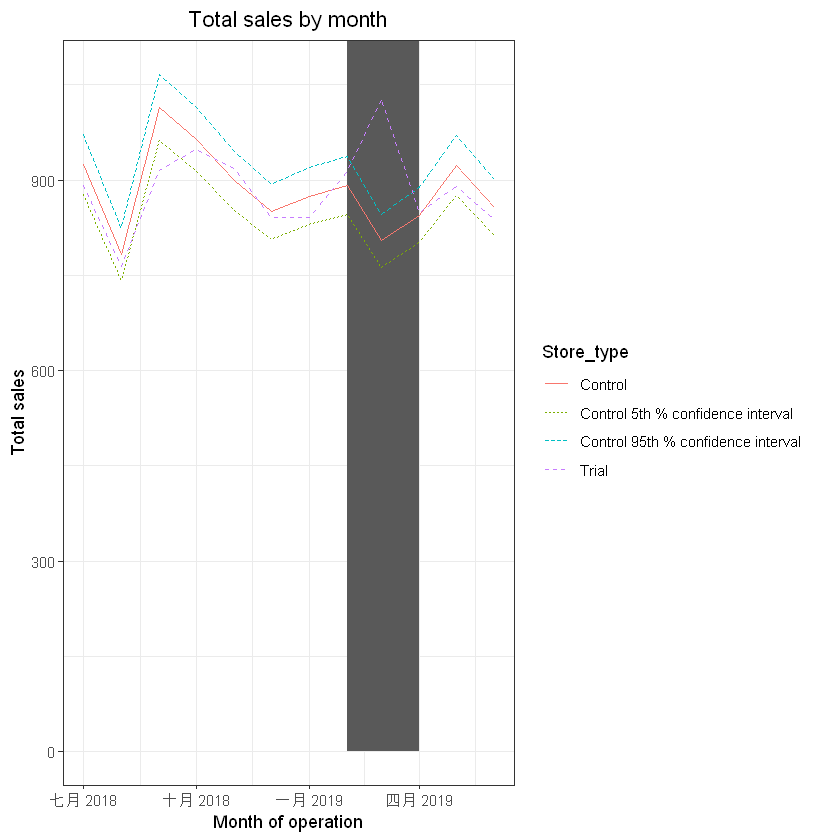

In [35]:
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR == control_store &
YEARMONTH < 201902, sum(totSales)]
#### Apply the scaling factor
measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][ ,
controlSales := totSales * scalingFactorForControlSales]
#### Calculate the percentage difference between scaled control sales and trial sales
#### When calculating percentage difference, remember to use absolute difference
percentageDiff <- merge(scaledControlSales[, c("YEARMONTH", "controlSales")],
measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],
by = "YEARMONTH"
)[, percentageDiff := abs(controlSales-totSales)/controlSales]

#### As our null hypothesis is that the trial period is the same as the pre-trial
#### period, let's take the standard deviation based on the scaled percentage difference
#### in the pre-trial period
#### Calculate the standard deviation of percentage differences during the pre-trial period
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom <- 7

#### Trial and control store total sales
#### Create a table with sales by store type and month.
#### We only need data for the trial and control store.
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/%100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
][Store_type %in% c("Trial", "Control"), ]

#### Calculate the 5th and 95th percentile for control store sales.
#### The 5th and 95th percentiles can be approximated by using two standard deviations away from the mean.
#### Recall that the variable stdDev earlier calculates standard deviation in percentages, and not dollar sales.
#### Control store 95th percentile
pastSales_Controls95 <- pastSales[Store_type == "Control",
][, totSales := totSales * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]

#### Control store 5th percentile
pastSales_Controls5 <- pastSales[Store_type == "Control",
][, totSales := totSales * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]

#### Then, create a combined table with columns from pastSales, pastSales_Controls95 and pastSales_Controls5
trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 , ymax =
Inf, color = NULL), show.legend = FALSE) +
  geom_line(aes(linetype = Store_type)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

The results show that the trial in store 86 is not significantly different to its
control store in the trial period as the trial store performance lies inside the 5%
to 95% confidence interval of the control store in two of the three trial months.
Let's have a look at assessing this for the number of customers as well.

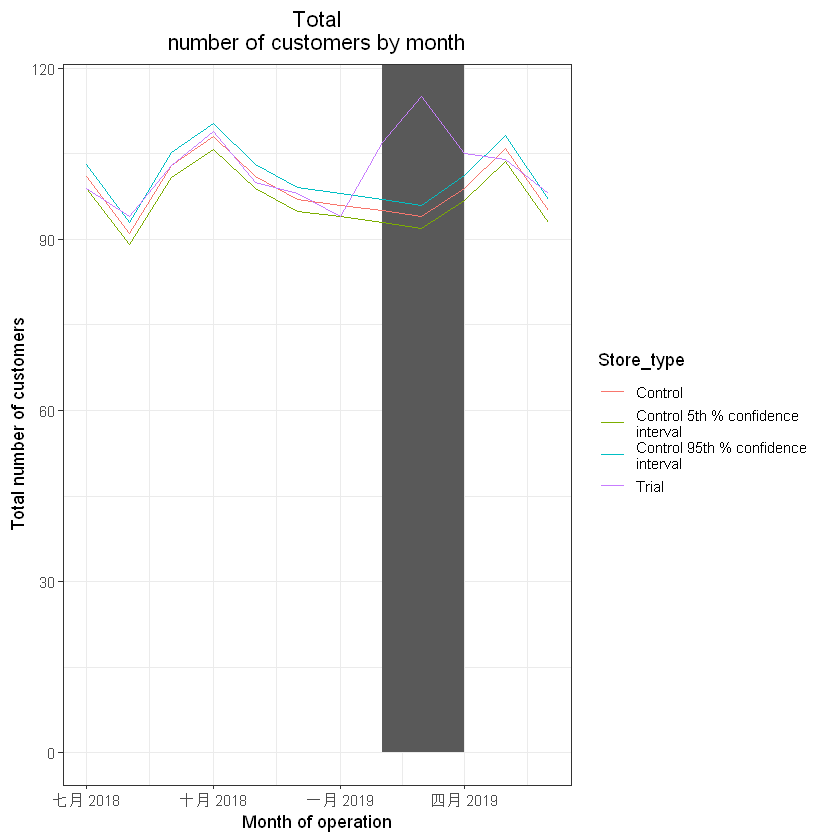

In [36]:
scalingFactorForControlCust <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR == control_store &
YEARMONTH < 201902, sum(nCustomers)]
#### Apply the scaling factor
measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,
                                            ][ , controlCustomers := nCustomers
* scalingFactorForControlCust
                                            ][, Store_type := ifelse(STORE_NBR
== trial_store, "Trial",
                                      ifelse(STORE_NBR == control_store,
"Control", "Other stores"))
]
#### Calculate the percentage difference between scaled control sales and trial sales
percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH",
"controlCustomers")],
                        measureOverTime[STORE_NBR == trial_store, c("nCustomers",
"YEARMONTH")],
                        by = "YEARMONTH"
                        )[, percentageDiff :=
abs(controlCustomers-nCustomers)/controlCustomers]
#### As our null hypothesis is that the trial period is the same as the pre-trial 
#### period, let's take the standard deviation based on the scaled percentage difference
#### in the pre-trial period
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom <- 7
#### Trial and control store number of customers
pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by =
c("YEARMONTH", "Store_type")
                              ][Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",
                                ][, nCusts := nCusts * (1 + stdDev * 2)
                                ][, Store_type := "Control 95th % confidence
interval"]
#### Control store 5th percentile
pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
                              ][, nCusts := nCusts * (1 - stdDev * 2)
                              ][, Store_type := "Control 5th % confidence
interval"]
trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95,
pastCustomers_Controls5)
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
  geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 , ymax =
Inf, color = NULL), show.legend = FALSE) +
  geom_line() +
  labs(x = "Month of operation", y = "Total number of customers", title = "Total
number of customers by month")

It looks like the number of customers is significantly higher in all of the three
months. This seems to suggest that the trial had a significant impact on increasing
the number of customers in trial store 86 but as we saw, sales were not
significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices,
impacting the results.

In [37]:
measureOverTime <- data[, .(totSales = sum(TOT_SALES),
nCustomers = uniqueN(LYLTY_CARD_NBR),
nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID),
avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY))
, by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]
#### Use the functions from earlier to calculate the correlation of the sales and number of customers of each potential control store to the trial store
trial_store <- 88
corr_nSales <- calculateCorrelation(preTrialMeasures, quote(totSales),trial_store)
corr_nCustomers <- calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)
#### Use the functions from earlier to calculate the magnitude distance of the sales and number of customers of each potential control store to the trial store
magnitude_nSales <- calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <- calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)
#### Create a combined score composed of correlation and magnitude by merging the correlations table and the magnitudes table, for each driver.
corr_weight <- 0.5
score_nSales <- merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))[ , scoreNSales := (corr_measure + mag_measure)/2]
score_nCustomers <- merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[ , scoreNCust := (corr_measure + mag_measure)/2]

#### Combine scores across the drivers by merging sales scores and customer scores, and compute a final combined score.
score_Control <- merge(score_nSales, score_nCustomers, by = c("Store1","Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]
#### Select control stores based on the highest matching store
#### (closest to 1 but not the store itself, i.e. the second ranked highest store)
#### Select control store for trial store 88
control_store <- score_Control[Store1 == trial_store, ][order(-finalControlScore)][2, Store2]
control_store

[1] 237

We've now found store 237 to be a suitable control store for trial store 88.
Again, let's check visually if the drivers are indeed similar in the period before
the trial.
We'll look at total sales first.

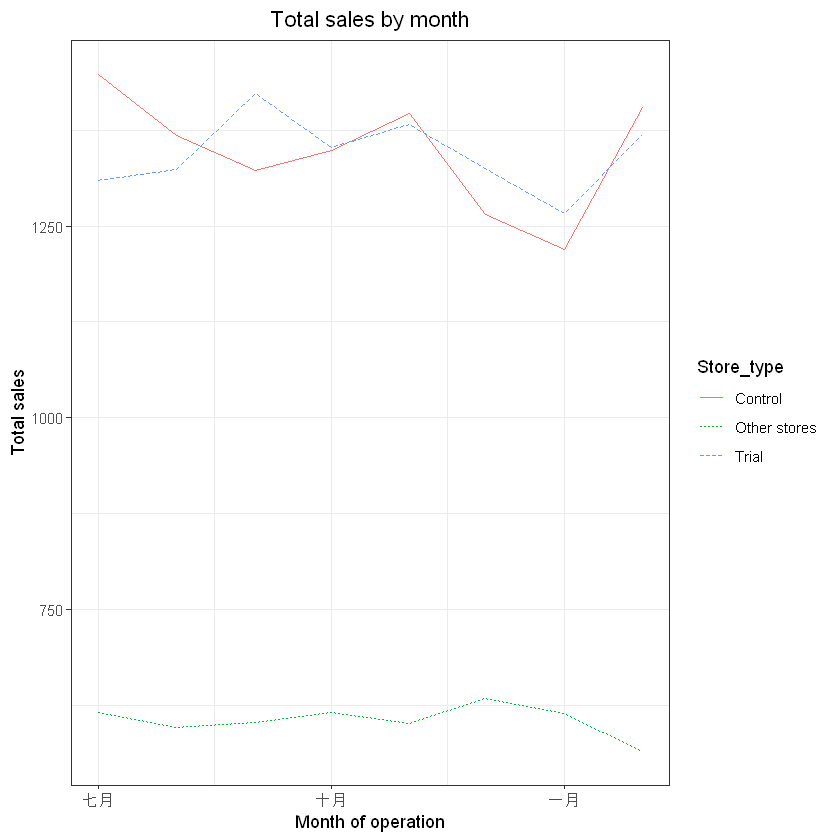

In [38]:
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH","Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
][YEARMONTH < 201903 , ]
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) +
geom_line(aes(linetype = Store_type)) +
labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

Great, the trial and control stores have similar total sales.
Next, number of customers.

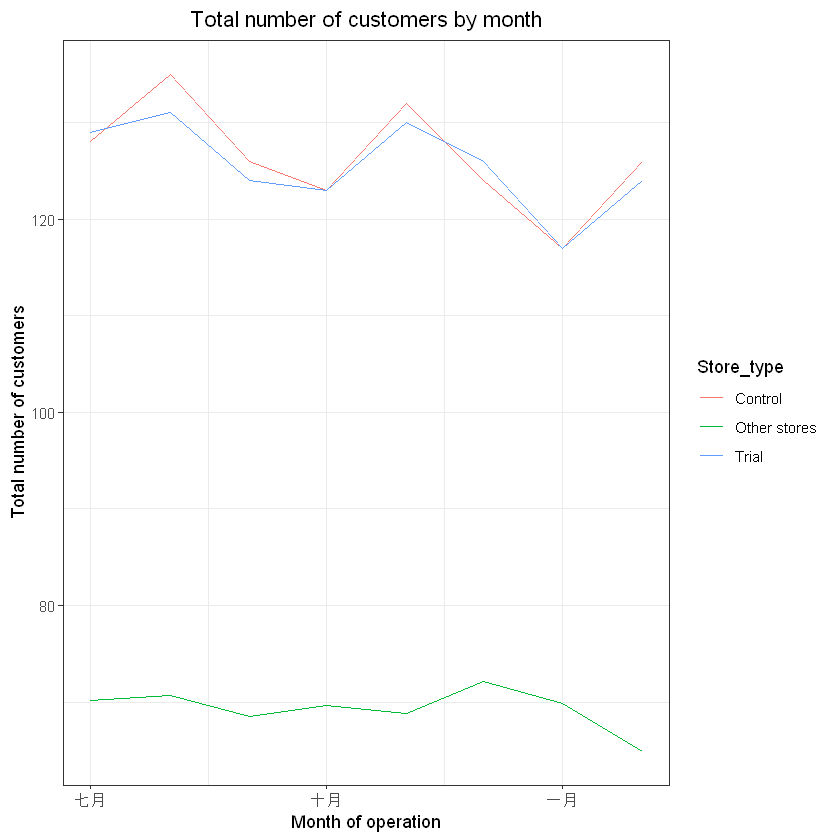

In [39]:
measureOverTimeCusts <- measureOverTime
pastCustomers <- measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/%
                                        100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
][YEARMONTH < 201903 , ]
ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) + 
  geom_line() + labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

Total number of customers of the control and trial stores are also similar.
Let's now assess the impact of the trial on sales.

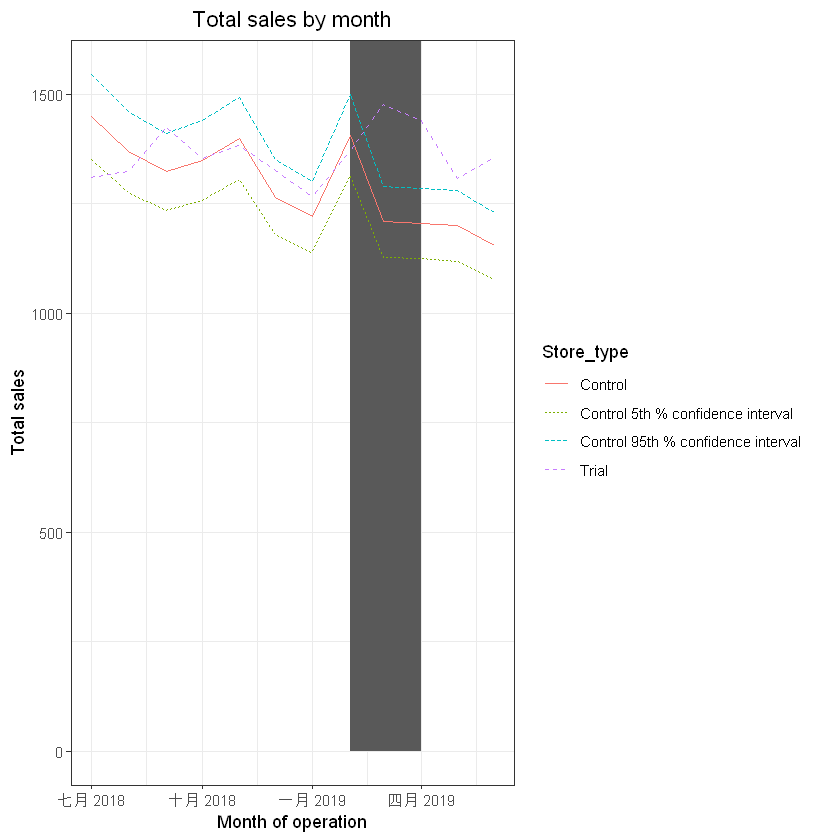

In [40]:
scalingFactorForControlSales <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(totSales)]

#### Apply the scaling factor
measureOverTimeSales <- measureOverTime
scaledControlSales <- measureOverTimeSales[STORE_NBR == control_store, ][ ,controlSales := totSales * scalingFactorForControlSales]

#### Calculate the absolute percentage difference between scaled control sales and trial sales
percentageDiff <- merge(scaledControlSales[, c("YEARMONTH", "controlSales")],measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],by = "YEARMONTH")[, percentageDiff := abs(controlSales-totSales)/controlSales]

#### As our null hypothesis is that the trial period is the same as the pre-trial period, 
#### let's take the standard deviation based on the scaled percentage difference in the pre-trial period
stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom <- 7
#### Trial and control store total sales
measureOverTimeSales <- measureOverTime
pastSales <- measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store, "Control", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
][, TransactionMonth := as.Date(paste(YEARMONTH %/%100, YEARMONTH %% 100, 1, sep = "-"), "%Y-%m-%d")
][Store_type %in% c("Trial", "Control"), ]
#### Control store 95th percentile
pastSales_Controls95 <- pastSales[Store_type == "Control",
][, totSales := totSales * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]
#### Control store 5th percentile
pastSales_Controls5 <- pastSales[Store_type == "Control",
][, totSales := totSales * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]
trialAssessment <- rbind(pastSales, pastSales_Controls95, pastSales_Controls5)
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) +
geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + 
  geom_line(aes(linetype = Store_type)) + 
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.
Let's have a look at assessing this for number of customers as well.

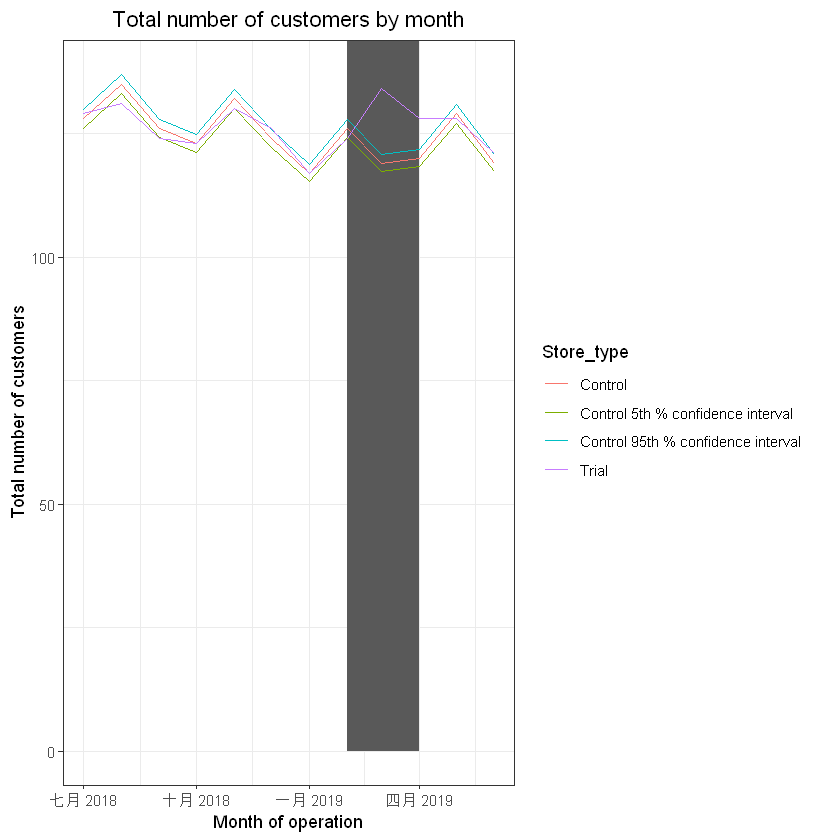

In [41]:
scalingFactorForControlCust <- preTrialMeasures[STORE_NBR == trial_store &
YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR ==
control_store & YEARMONTH < 201902, sum(nCustomers)]

#### Apply the scaling factor
measureOverTimeCusts <- measureOverTime
scaledControlCustomers <- measureOverTimeCusts[STORE_NBR == control_store,
][ , controlCustomers := nCustomers * scalingFactorForControlCust
][, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
ifelse(STORE_NBR == control_store,"Control", "Other stores"))
]
#### Calculate the absolute percentage difference between scaled control sales and trial sales
percentageDiff <- merge(scaledControlCustomers[, c("YEARMONTH","controlCustomers")],measureOverTime[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")],
by = "YEARMONTH")[, percentageDiff := abs(controlCustomers-nCustomers)/controlCustomers]

#### As our null hypothesis is that the trial period is the same as the pre-trial
#### period, let's take the standard deviation based on the scaled percentage #### difference in the pre-trial period

stdDev <- sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom <- 7 
# note that there are 8 months in the pre-trial period hence 8 - 1 = 7 degrees of freedom
#### Trial and control store number of customers
pastCustomers <- measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")
][Store_type %in% c("Trial", "Control"), ]

#### Control store 95th percentile
pastCustomers_Controls95 <- pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 + stdDev * 2)
][, Store_type := "Control 95th % confidence interval"]
#### Control store 5th percentile
pastCustomers_Controls5 <- pastCustomers[Store_type == "Control",
][, nCusts := nCusts * (1 - stdDev * 2)
][, Store_type := "Control 5th % confidence interval"]
#### Combine the tables pastSales, pastSales_Controls95, pastSales_Controls5
trialAssessment <- rbind(pastCustomers, pastCustomers_Controls95,pastCustomers_Controls5)
#### Plotting these in one nice graph
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) +
  geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,],
aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 ,
ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() + 
labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

Total number of customers in the trial period for the trial store is significantly
higher than the control store for two out of three months, which indicates a
positive trial effect.
## Conclusion
Good work! We've found control stores 233, 155, 237 for trial stores 77, 86 and 88
respectively.
The results for trial stores 77 and 88 during the trial period show a significant
difference in at least two of the three trial months but this is not the case for
trial store 86. We can check with the client if the implementation of the trial was
different in trial store 86 but overall, the trial shows a significant increase in
sales. Now that we have finished our analysis, we can prepare our presentation to
the Category Manager.